In [10]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math

import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag,ngrams,word_tokenize
import xgboost as xgb


from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#Disable pandas warnings
pd.options.mode.chained_assignment = None

In [18]:
train=pd.read_csv('/Users/adityavyas/Desktop/Machine Learning and Data Science/Datasets/Quora prediction/train.csv')
test=pd.read_csv('/Users/adityavyas/Desktop/Machine Learning and Data Science/Datasets/Quora prediction/test.csv')

IOError: File /Users/adityavyas/Desktop/Machine Learning and Data Science/Datasets/Quora prediction/train.csv does not exist

In [4]:
train.shape,test.shape

((404290, 6), (2345796, 3))

In [6]:
train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
test.head(4)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?


In [8]:
train.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [9]:
train.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       2
is_duplicate    0
dtype: int64

In [10]:
test.isnull().sum()

test_id      0
question1    2
question2    4
dtype: int64

In [11]:
stops = set(stopwords.words("english"))

In [12]:
train['question2'][pd.isnull(train['question2'])]=''
test['question1'][pd.isnull(test['question1'])]=''
test['question2'][pd.isnull(test['question2'])]=''


In [13]:
train.isnull().sum(), test.isnull().sum()

(id              0
 qid1            0
 qid2            0
 question1       0
 question2       0
 is_duplicate    0
 dtype: int64, test_id      0
 question1    0
 question2    0
 dtype: int64)

In [14]:
#Applying on train data
train['ques1_len']=train['question1'].str.len()
train['ques2_len']=train['question2'].str.len()

train['ques1_wordcount']=train['question1'].apply(lambda row: len(row.split()))
train['ques2_wordcount']=train['question2'].apply(lambda row: len(row.split())) 

#Applying on the test data
test['ques1_len']=test['question1'].str.len()
test['ques2_len']=test['question2'].str.len()

test['ques1_wordcount']=test['question1'].apply(lambda row: len(row.split()))
test['ques2_wordcount']=test['question2'].apply(lambda row: len(row.split()))

In [15]:
def preprocess_questions(row):
    ques1=row['question1']
    ques2=row['question2']

    #Removing stopwords
    ques1_words=[word for word in ques1.lower().split() if word not in stops]
    ques2_words=[word for word in ques2.lower().split() if word not in stops]

    #Removing punctuations from words
    ques1_no_punc=[word.strip(string.punctuation) for word in ques1_words]
    ques2_no_punc=[word.strip(string.punctuation) for word in ques2_words]
    
    same_words=[word for word in ques1_no_punc if word in ques2_no_punc]
    if len(same_words)>0:
        return float(len(same_words))/float(len(ques1_no_punc)+len(ques2_no_punc))       
    else:
        return 0.00
    
train['word_share']=train.apply(lambda row: preprocess_questions(row),1)
test['word_share']=test.apply(lambda row: preprocess_questions(row),1)

In [16]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,ques1_len,ques2_len,ques1_wordcount,ques2_wordcount,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,0.461538
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,0.230769
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,0.181818
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,0.133333


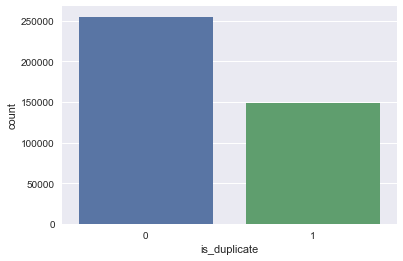

In [17]:
sns.countplot('is_duplicate', data=train)

In [18]:
#Percentage of duplicate and non-duplicate questions

is_dup=train['is_duplicate'].value_counts()
(is_dup/is_dup.sum())*100

0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64

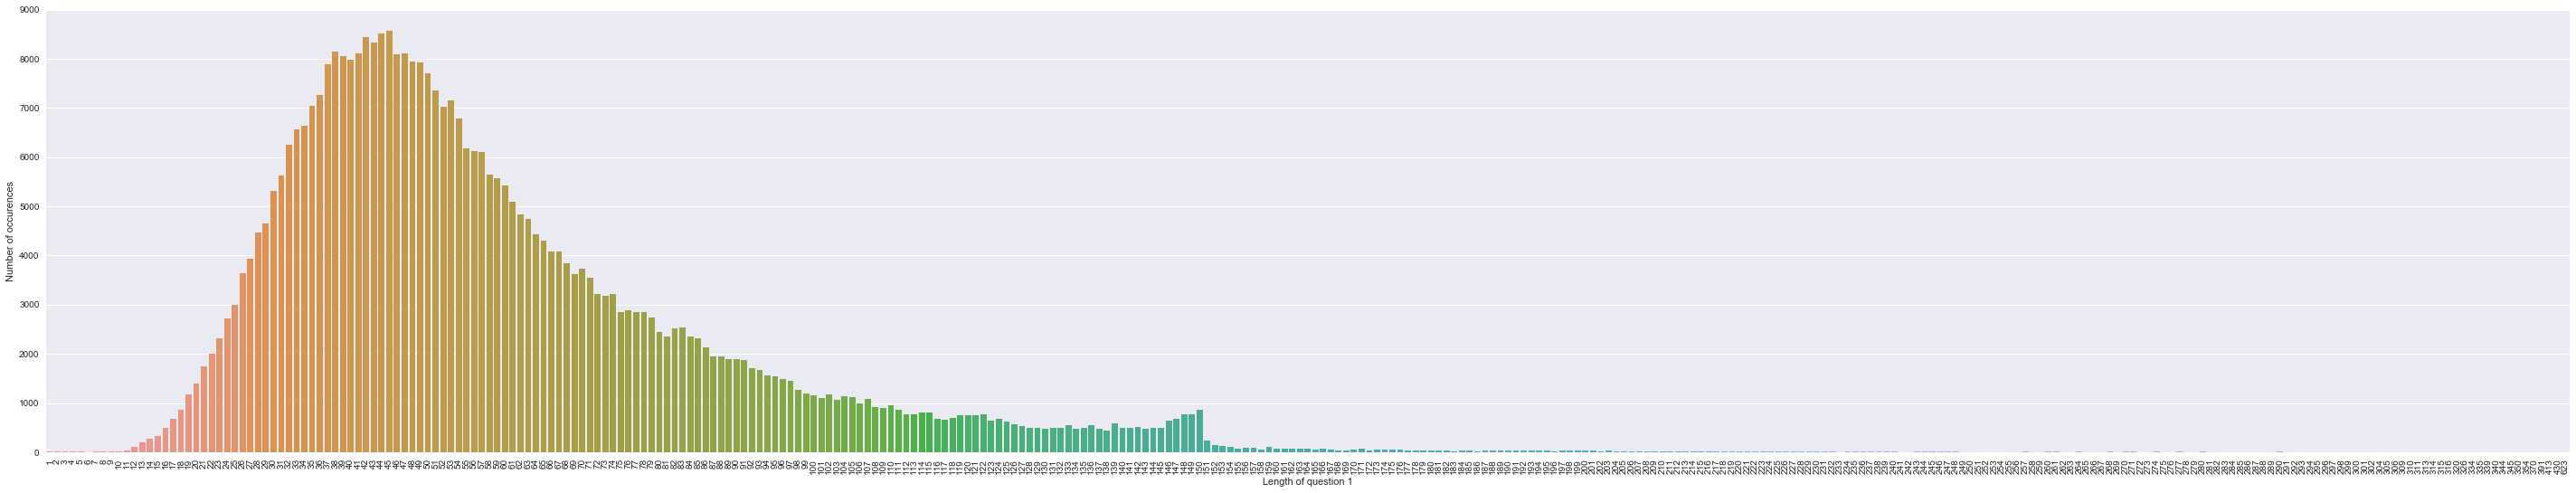

In [19]:
#Let us get a visualisation of the question lengths

ques1len_occurences=train['ques1_len'].value_counts()
plt.figure(figsize=(50,9))
sns.barplot(ques1len_occurences.index, ques1len_occurences.values)
plt.xlabel('Length of question 1')
plt.ylabel('Number of occurences')
plt.xticks(rotation='vertical')
plt.show()

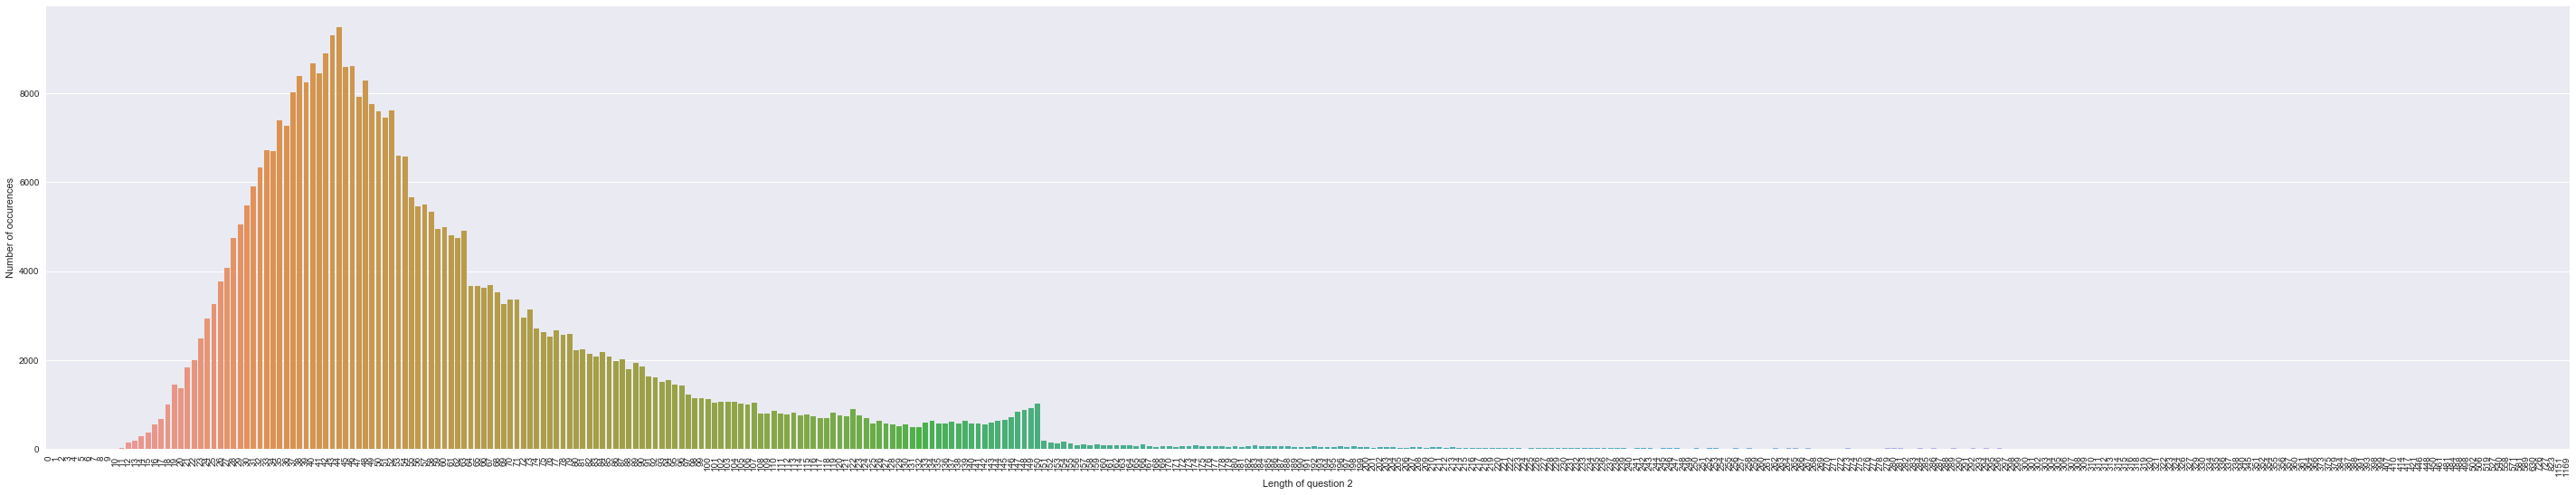

In [20]:
ques2len_occurences=train['ques2_len'].value_counts()
plt.figure(figsize=(50,9))
sns.barplot(ques2len_occurences.index, ques2len_occurences.values)
plt.xlabel('Length of question 2')
plt.ylabel('Number of occurences')
plt.xticks(rotation='vertical')
plt.show()

We see that most of the question lengths are of around values 30-60. Now let us check the distribution of word count
in each question. There is a dip at 150 because Quora allows maximum of 150 characters in the questions.

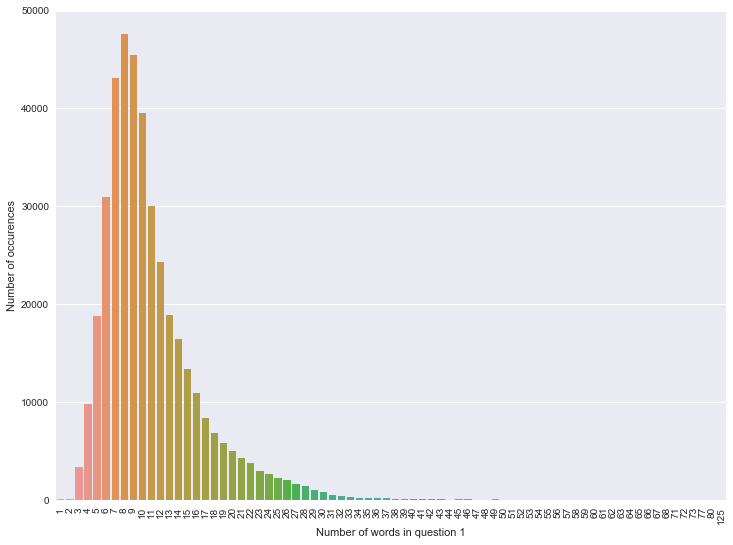

In [21]:
ques1_wordcount=train['ques1_wordcount'].value_counts()
plt.figure(figsize=(12,9))
sns.barplot(ques1_wordcount.index, ques1_wordcount.values)
plt.xlabel('Number of words in question 1')
plt.ylabel('Number of occurences')
plt.xticks(rotation='vertical')
plt.show()

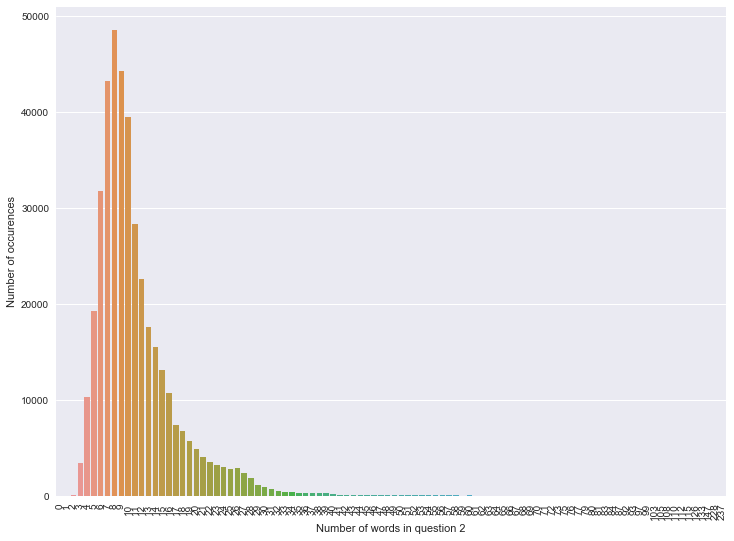

In [22]:
ques2_wordcount=train['ques2_wordcount'].value_counts()
plt.figure(figsize=(12,9))
sns.barplot(ques2_wordcount.index, ques2_wordcount.values)
plt.xlabel('Number of words in question 2')
plt.ylabel('Number of occurences')
plt.xticks(rotation='vertical')
plt.show()

So there are questions with just 1 or 2 words also. Interesting! Also the maximum number of words reaches 237 for the second question while for first question it reaches 125.

In [23]:
def generate_ngrams(x,n):
    ques_tokens=[word.strip(string.punctuation) for word in x.lower().split()]
    ques_ngram=[word for word in ngrams(ques_tokens, n)]
    return ques_ngram
    
#Generate unigrams, bigrams and trigrams for questions
train['ques1_unigram']=train['question1'].apply(lambda x: generate_ngrams(x, 1))
train['ques1_bigram']=train['question1'].apply(lambda x: generate_ngrams(x, 2))
train['ques1_trigram']=train['question1'].apply(lambda x: generate_ngrams(x, 3))

train['ques2_unigram']=train['question2'].apply(lambda x: generate_ngrams(x, 1))
train['ques2_bigram']=train['question2'].apply(lambda x: generate_ngrams(x, 2))
train['ques2_trigram']=train['question2'].apply(lambda x: generate_ngrams(x, 3))

train['ques1_bigram_len']=train['ques1_bigram'].apply(lambda x: len(x))
train['ques1_trigram_len']=train['ques1_trigram'].apply(lambda x: len(x))

train['ques2_bigram_len']=train['ques2_bigram'].apply(lambda x: len(x))
train['ques2_trigram_len']=train['ques2_trigram'].apply(lambda x: len(x))

In [24]:
def generate_common_ngrams_ratio(row,n):
    common_ngrams_len=0
    if n==2:
        ques1_bigrams=row['ques1_bigram']
        ques2_bigrams=row['ques2_bigram']
        
        common_ngrams_len = len(set(ques1_bigrams).intersection(set(ques2_bigrams)))
        common_ngrams_ratio = float(common_ngrams_len) / max(len(set(ques1_bigrams).union(set(ques2_bigrams))),1) 
    if n==3:
        ques1_trigrams=row['ques1_trigram']
        ques2_trigrams=row['ques2_trigram']
        
        common_ngrams_len = len(set(ques1_trigrams).intersection(set(ques2_trigrams)))
        common_ngrams_ratio = float(common_ngrams_len) / max(len(set(ques1_trigrams).union(set(ques2_trigrams))),1)
        
    return common_ngrams_ratio
        

train['common_bigram_ratio']=train.apply(lambda x: generate_common_ngrams_ratio(x,2),1)
train['common_trigram_ratio']=train.apply(lambda x: generate_common_ngrams_ratio(x,3),1)


In [25]:
#Applying the same to test dataset

test['ques1_unigram']=test['question1'].apply(lambda x: generate_ngrams(x, 1))
test['ques1_bigram']=test['question1'].apply(lambda x: generate_ngrams(x, 2))
test['ques1_trigram']=test['question1'].apply(lambda x: generate_ngrams(x, 3))

test['ques2_unigram']=test['question2'].apply(lambda x: generate_ngrams(x, 1))
test['ques2_bigram']=test['question2'].apply(lambda x: generate_ngrams(x, 2))
test['ques2_trigram']=test['question2'].apply(lambda x: generate_ngrams(x, 3))

test['ques1_bigram_len']=test['ques1_bigram'].apply(lambda x: len(x))
test['ques1_trigram_len']=test['ques1_trigram'].apply(lambda x: len(x))

test['ques2_bigram_len']=test['ques2_bigram'].apply(lambda x: len(x))
test['ques2_trigram_len']=test['ques2_trigram'].apply(lambda x: len(x))

In [26]:
test['common_bigram_ratio']=test.apply(lambda x: generate_common_ngrams_ratio(x,2),1)
test['common_trigram_ratio']=test.apply(lambda x: generate_common_ngrams_ratio(x,3),1)

In [27]:
train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,ques1_len,ques2_len,ques1_wordcount,ques2_wordcount,...,ques1_trigram,ques2_unigram,ques2_bigram,ques2_trigram,ques1_bigram_len,ques1_trigram_len,ques2_bigram_len,ques2_trigram_len,common_bigram_ratio,common_trigram_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,...,"[(what, is, the), (is, the, step), (the, step,...","[(what,), (is,), (the,), (step,), (by,), (step...","[(what, is), (is, the), (the, step), (step, by...","[(what, is, the), (is, the, step), (the, step,...",13,12,11,10,0.846154,0.833333


In [28]:
test.head(1)

,test_id,question1,question2,ques1_len,ques2_len,ques1_wordcount,ques2_wordcount,word_share,ques1_unigram,ques1_bigram,ques1_trigram,ques2_unigram,ques2_bigram,ques2_trigram,ques1_bigram_len,ques1_trigram_len,ques2_bigram_len,ques2_trigram_len,common_bigram_ratio,common_trigram_ratio
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,57,68,11,14,0.25,"[(how,), (does,), (the,), (surface,), (pro,), ...","[(how, does), (does, the), (the, surface), (su...","[(how, does, the), (does, the, surface), (the,...","[(why,), (did,), (microsoft,), (choose,), (cor...","[(why, did), (did, microsoft), (microsoft, cho...","[(why, did, microsoft), (did, microsoft, choos...",10,9,13,12,0.045455,0.0


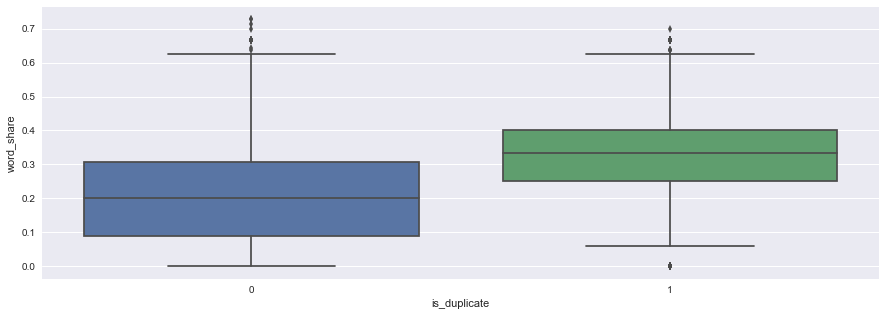

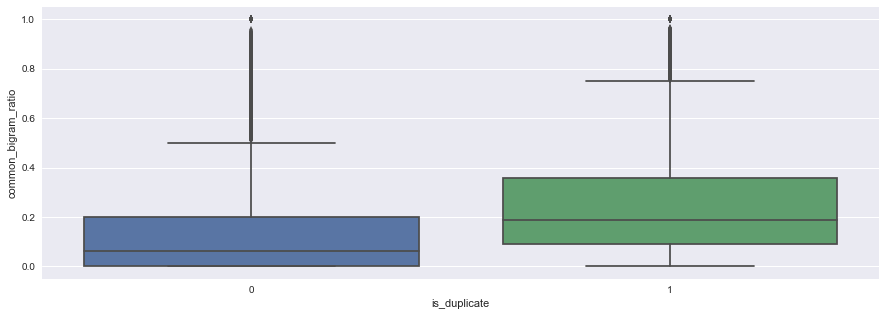

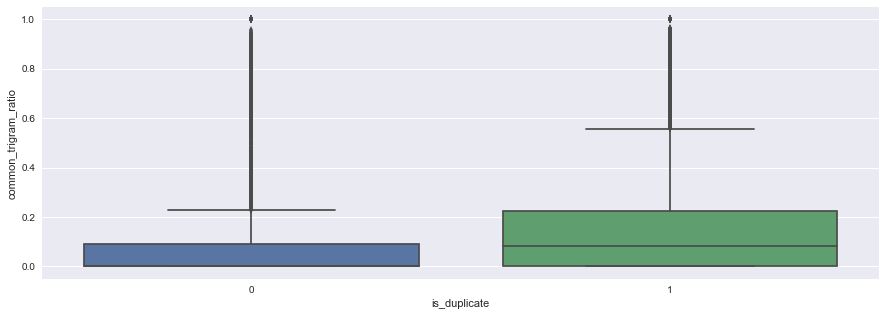

In [29]:
plt.figure(1,figsize=(15,5))
sns.boxplot(x='is_duplicate', y='word_share', data=train)

plt.figure(2, figsize=(15,5))
sns.boxplot(x='is_duplicate', y='common_bigram_ratio', data=train)

plt.figure(3, figsize=(15,5))
sns.boxplot(x='is_duplicate', y='common_trigram_ratio', data=train)


We see that the unigram and bigram ratios can easily divide the data into 2 groups. Trigram features are not so good at dividing the features into 2 sets. 

(-0.5, 1439.5, 1079.5, -0.5)

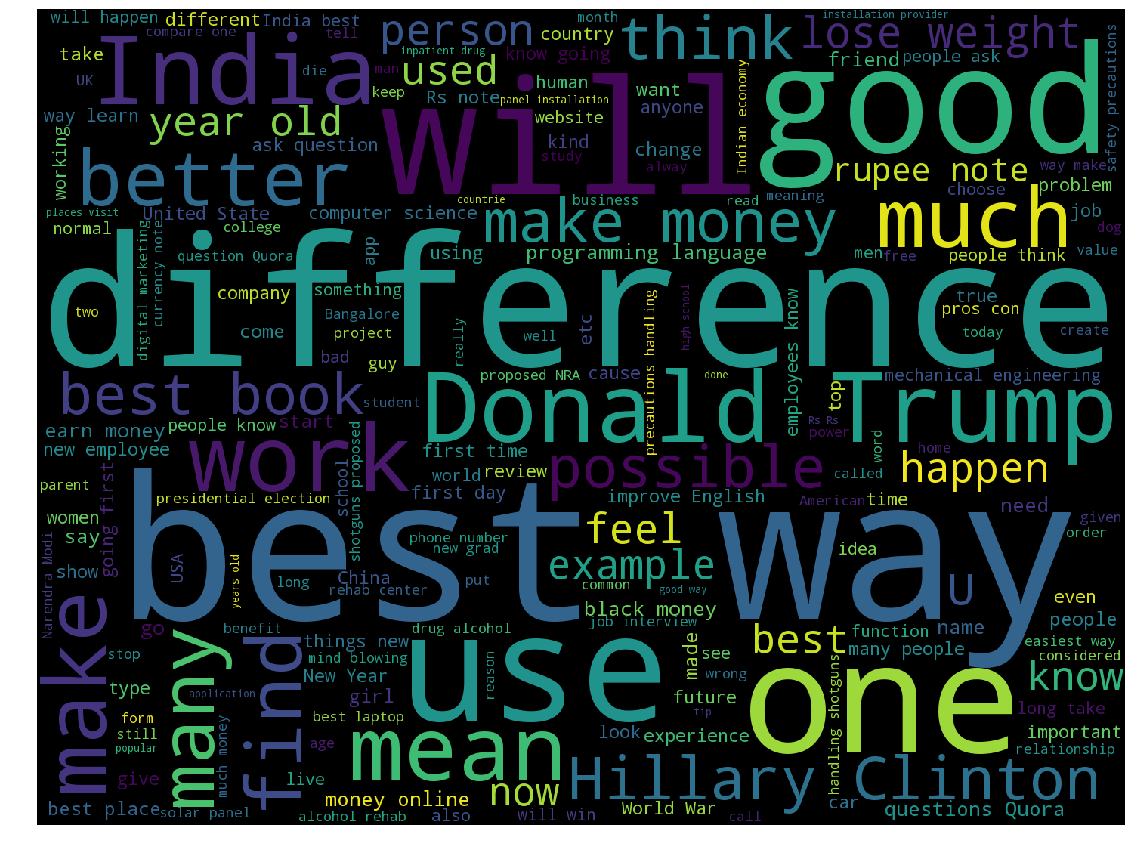

In [30]:
#Let us check which words are more frequent

from wordcloud import WordCloud
train_words=pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
cloud=WordCloud(width=1440, height=1080).generate(" ".join(train_words.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

So Donald Trump leads the word count with a very high frequency of counts. Not at all surprising! Also 'best way' is more frequently asked. 

We now plot the word_match_share to see how it is varying with the target variable is_duplicate.

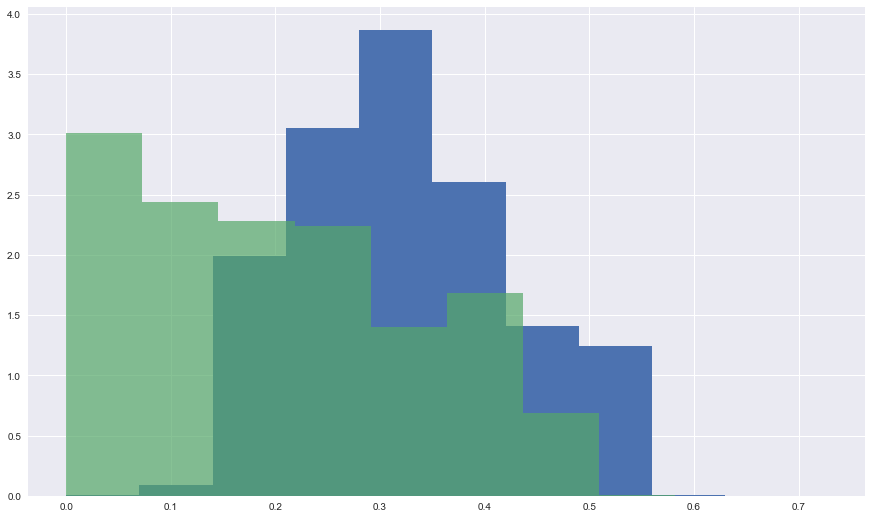

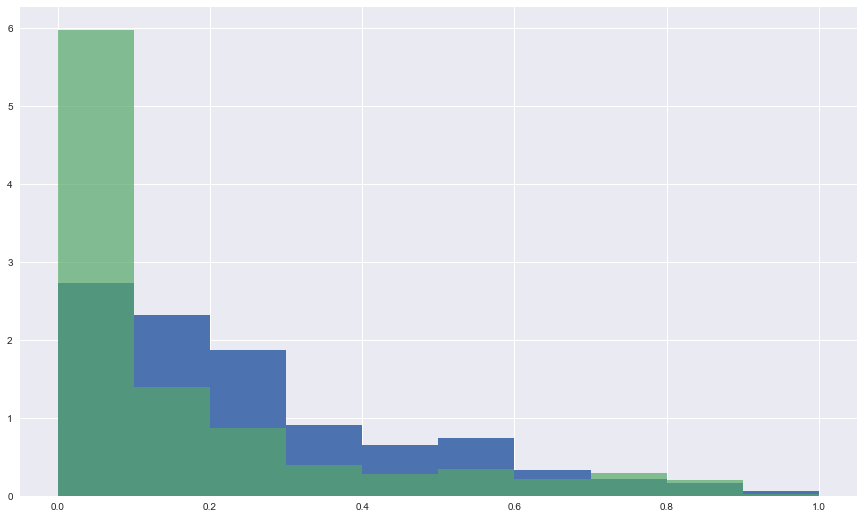

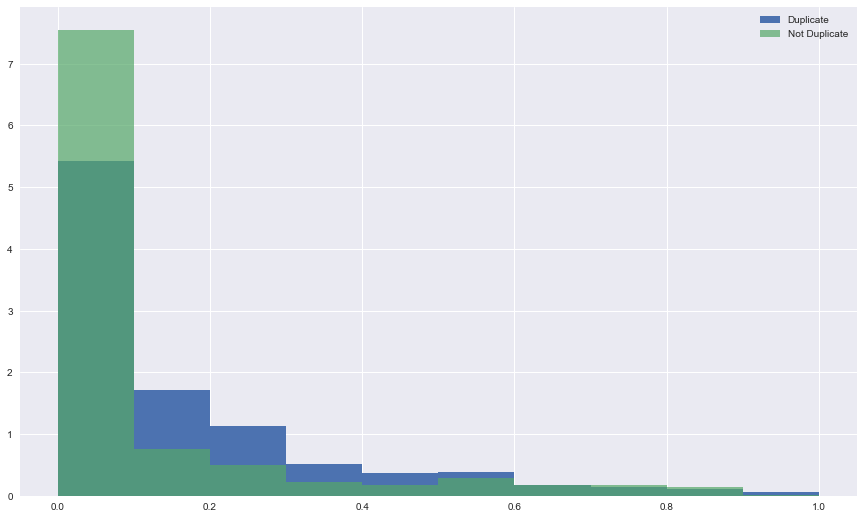

In [31]:
plt.figure(1,figsize=(15,9))
plt.hist(train['word_share'][train['is_duplicate']==1],label='Duplicate',normed=True)
plt.hist(train['word_share'][train['is_duplicate']==0],label='Not Duplicate',normed=True,alpha=0.7)

plt.figure(2,figsize=(15,9))
plt.hist(train['common_bigram_ratio'][train['is_duplicate']==1],label='Duplicate',normed=True)
plt.hist(train['common_bigram_ratio'][train['is_duplicate']==0],label='Not Duplicate',normed=True,alpha=0.7)

plt.figure(3,figsize=(15,9))
plt.hist(train['common_trigram_ratio'][train['is_duplicate']==1],label='Duplicate',normed=True)
plt.hist(train['common_trigram_ratio'][train['is_duplicate']==0],label='Not Duplicate',normed=True,alpha=0.7)

plt.legend()
plt.show()

 We prove our observation right regarding unigrams and bigrams being more important than trigrams. Now let us rebalance the data.

In [33]:
#Adding some more features

train['ques_wordcount_ratio']=(train['ques1_wordcount'])/(train['ques2_wordcount'])
test['ques_wordcount_ratio']=(test['ques1_wordcount'])/(test['ques2_wordcount'])

train['ques_len_difference']=np.abs(train['ques1_len']-train['ques2_len'])
test['ques_len_difference']=np.abs(test['ques1_len']-test['ques2_len'])

In [53]:
tfidf=TfidfVectorizer(stop_words='english', ngram_range=(1,1))
tfidf_corpus=pd.Series(train['question1'].tolist()+train['question2'].tolist()+test['question1'].tolist()+test['question2'].tolist()).astype(str)
tfidf.fit_transform(tfidf_corpus)

<5500172x121140 sparse matrix of type '<type 'numpy.float64'>'
	with 28389422 stored elements in Compressed Sparse Row format>

In [57]:
#TF-IDF on training data
train['tfidf_sum_ques1']=train['question1'].apply(lambda x: np.sum(tfidf.transform([str(x)]).data))
train['tfidf_sum_ques2']=train['question2'].apply(lambda x: np.sum(tfidf.transform([str(x)]).data))
train['tfidf_mean_ques1']=train['question1'].apply(lambda x: np.mean(tfidf.transform([str(x)]).data))
train['tfidf_mean_ques2']=train['question2'].apply(lambda x: np.mean(tfidf.transform([str(x)]).data))
train['tfidf_len_ques1']=train['question1'].apply(lambda x: len(tfidf.transform([str(x)]).data))
train['tfidf_len_ques2']=train['question2'].apply(lambda x: len(tfidf.transform([str(x)]).data))

In [ ]:
test['tfidf_sum_ques1']=test['question1'].apply(lambda x: np.sum(tfidf.transform([str(x)]).data))
test['tfidf_sum_ques2']=test['question2'].apply(lambda x: np.sum(tfidf.transform([str(x)]).data))
test['tfidf_mean_ques1']=test['question1'].apply(lambda x: np.mean(tfidf.transform([str(x)]).data))
test['tfidf_mean_ques2']=test['question2'].apply(lambda x: np.mean(tfidf.transform([str(x)]).data))
test['tfidf_len_ques1']=test['question1'].apply(lambda x: len(tfidf.transform([str(x)]).data))
test['tfidf_len_ques2']=test['question2'].apply(lambda x: len(tfidf.transform([str(x)]).data))

In [49]:
train_drop_columns=['id','is_duplicate','qid1','qid2','question1','question2','ques1_unigram','ques1_bigram','ques1_trigram',
             'ques2_unigram','ques2_bigram','ques2_trigram']
test_drop_columns=['test_id','question1','question2','ques1_unigram','ques1_bigram','ques1_trigram',
             'ques2_unigram','ques2_bigram','ques2_trigram']


In [52]:
x_train=train.drop(train_drop_columns,1)
y_train=train['is_duplicate']

x_train_dup = x_train[y_train==1]
x_train_non_dup = x_train[y_train==0]

X_TRAIN = np.vstack([x_train_non_dup, x_train_dup, x_train_non_dup, x_train_non_dup])
Y_TRAIN = np.array([0]*x_train_non_dup.shape[0] + [1]*x_train_dup.shape[0] + [0]*x_train_non_dup.shape[0] + [0]*x_train_non_dup.shape[0])
#x_train_dup.shape[0]

In [53]:
#Split the train dataset into validation and training set

X_train, X_val, Y_train, Y_val = train_test_split(X_TRAIN,Y_TRAIN, test_size=0.2, random_state=4242)

In [54]:
# XGBoost Model 1
params1 = {}
params1['objective'] = 'binary:logistic'
params1['eval_metric'] = 'logloss'
params1['eta'] = 0.02
params1['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=Y_train)
d_val = xgb.DMatrix(X_val, label=Y_val)

watchlist = [(d_train, 'train'), (d_val, 'validation')]

bst1 = xgb.train(params1, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68269	validation-logloss:0.682653
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.597515	validation-logloss:0.59717
[20]	train-logloss:0.537729	validation-logloss:0.537163
[30]	train-logloss:0.494532	validation-logloss:0.493793
[40]	train-logloss:0.462609	validation-logloss:0.461724
[50]	train-logloss:0.438504	validation-logloss:0.437494
[60]	train-logloss:0.420207	validation-logloss:0.419087
[70]	train-logloss:0.406178	validation-logloss:0.404961
[80]	train-logloss:0.395318	validation-logloss:0.394024
[90]	train-logloss:0.386855	validation-logloss:0.385497
[100]	train-logloss:0.38023	validation-logloss:0.378817
[110]	train-logloss:0.375015	validation-logloss:0.373558
[120]	train-logloss:0.370884	validation-logloss:0.369395
[130]	train-logloss:0.367622	validation-logloss:0.366102
[140]	train-logloss:0.365008	validation-logloss:0.36346

In [55]:
# XGBoost Model 2
params2 = {}
params2['objective'] = 'binary:logistic'
params2['eval_metric'] = 'logloss'
params2['eta'] = 0.05
params2['max_depth'] = 5

d_train = xgb.DMatrix(X_train, label=Y_train)
d_val = xgb.DMatrix(X_val, label=Y_val)

watchlist = [(d_train, 'train'), (d_val, 'validation')]

bst2 = xgb.train(params2, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.667222	validation-logloss:0.667137
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.505544	validation-logloss:0.504852
[20]	train-logloss:0.432561	validation-logloss:0.431489
[30]	train-logloss:0.395875	validation-logloss:0.394551
[40]	train-logloss:0.376418	validation-logloss:0.374942
[50]	train-logloss:0.365517	validation-logloss:0.363976
[60]	train-logloss:0.35943	validation-logloss:0.357869
[70]	train-logloss:0.355993	validation-logloss:0.354454
[80]	train-logloss:0.353911	validation-logloss:0.352381
[90]	train-logloss:0.352567	validation-logloss:0.351049
[100]	train-logloss:0.351569	validation-logloss:0.350089
[110]	train-logloss:0.350768	validation-logloss:0.349331
[120]	train-logloss:0.350056	validation-logloss:0.348675
[130]	train-logloss:0.349417	validation-logloss:0.348094
[140]	train-logloss:0.348876	validation-logloss:0.347

In [56]:
# XGBoost Model 3
params3 = {}
params3['objective'] = 'binary:logistic'
params3['eval_metric'] = 'logloss'
params3['eta'] = 0.1
params3['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=Y_train)
d_val = xgb.DMatrix(X_val, label=Y_val)

watchlist = [(d_train, 'train'), (d_val, 'validation')]

bst3 = xgb.train(params3, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.642972	validation-logloss:0.64279
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.428162	validation-logloss:0.427053
[20]	train-logloss:0.377138	validation-logloss:0.375666
[30]	train-logloss:0.361863	validation-logloss:0.360248
[40]	train-logloss:0.356769	validation-logloss:0.355122
[50]	train-logloss:0.354591	validation-logloss:0.352909
[60]	train-logloss:0.353171	validation-logloss:0.351555
[70]	train-logloss:0.352106	validation-logloss:0.350563
[80]	train-logloss:0.350763	validation-logloss:0.349303
[90]	train-logloss:0.349719	validation-logloss:0.348318
[100]	train-logloss:0.348785	validation-logloss:0.347428
[110]	train-logloss:0.348216	validation-logloss:0.346905
[120]	train-logloss:0.347487	validation-logloss:0.346214
[130]	train-logloss:0.346921	validation-logloss:0.345708
[140]	train-logloss:0.346431	validation-logloss:0.345

In [57]:
# XGBoost Model 4
params4 = {}
params4['objective'] = 'binary:logistic'
params4['eval_metric'] = 'logloss'
params4['eta'] = 0.125
params4['max_depth'] = 6

d_train = xgb.DMatrix(X_train, label=Y_train)
d_val = xgb.DMatrix(X_val, label=Y_val)

watchlist = [(d_train, 'train'), (d_val, 'validation')]

bst4 = xgb.train(params4, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.630451	validation-logloss:0.630226
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.402607	validation-logloss:0.401413
[20]	train-logloss:0.361234	validation-logloss:0.35989
[30]	train-logloss:0.351366	validation-logloss:0.350147
[40]	train-logloss:0.348396	validation-logloss:0.347345
[50]	train-logloss:0.346504	validation-logloss:0.34565
[60]	train-logloss:0.344892	validation-logloss:0.344259
[70]	train-logloss:0.343411	validation-logloss:0.343045
[80]	train-logloss:0.342232	validation-logloss:0.342081
[90]	train-logloss:0.341504	validation-logloss:0.341614
[100]	train-logloss:0.34051	validation-logloss:0.340846
[110]	train-logloss:0.33975	validation-logloss:0.340319
[120]	train-logloss:0.339104	validation-logloss:0.339883
[130]	train-logloss:0.338546	validation-logloss:0.339553
[140]	train-logloss:0.337779	validation-logloss:0.339053

In [59]:
x_test=np.array(test.drop(test_drop_columns,1))
d_test = xgb.DMatrix(x_test)

p_test1 = bst1.predict(d_test)
p_test2 = bst2.predict(d_test)
p_test3 = bst3.predict(d_test)
p_test4 = bst4.predict(d_test)


sub = pd.DataFrame()
sub['test_id'] = test['test_id']
sub['is_duplicate1'] = p_test1
sub['is_duplicate2'] = p_test2
sub['is_duplicate3'] = p_test3
sub['is_duplicate4'] = p_test4
#sub.to_csv('/Users/adityavyas/Desktop/simple_xgb.csv', index=False)

In [66]:
sub.drop('is_duplicate_ensemble',1,inplace=True)

In [83]:
def get_ensemble(x):
    preds=np.array([x['is_duplicate1'],x['is_duplicate2'],x['is_duplicate3'],x['is_duplicate4']])
    return np.mean(preds)

sub['is_duplicate_ensemble']=sub.apply(lambda x:get_ensemble(x),1)

In [85]:
sub2[['test_id','is_duplicate']]=sub[['test_id','is_duplicate2']]
sub3[['test_id','is_duplicate']]=sub[['test_id','is_duplicate3']]
sub4[['test_id','is_duplicate']]=sub[['test_id','is_duplicate4']]
sub5[['test_id','is_duplicate']]=sub[['test_id','is_duplicate_ensemble']]

In [89]:
sub2.to_csv('/Users/adityavyas/Desktop/simple_xgb2.csv', index=False)
sub3.to_csv('/Users/adityavyas/Desktop/simple_xgb3.csv', index=False)
sub4.to_csv('/Users/adityavyas/Desktop/simple_xgb4.csv', index=False)
sub5.to_csv('/Users/adityavyas/Desktop/simple_xgb5.csv', index=False)

In [47]:
train.columns

Index([u'id', u'qid1', u'qid2', u'question1', u'question2', u'is_duplicate',
       u'ques1_len', u'ques2_len', u'ques1_wordcount', u'ques2_wordcount',
       u'word_share', u'ques1_unigram', u'ques1_bigram', u'ques1_trigram',
       u'ques2_unigram', u'ques2_bigram', u'ques2_trigram',
       u'ques1_bigram_len', u'ques1_trigram_len', u'ques2_bigram_len',
       u'ques2_trigram_len', u'common_bigram_ratio', u'common_trigram_ratio',
       u'ques_wordcount_ratio'],
      dtype='object')

In [48]:
test.columns

Index([u'test_id', u'question1', u'question2', u'ques1_len', u'ques2_len',
       u'ques1_wordcount', u'ques2_wordcount', u'word_share', u'ques1_unigram',
       u'ques1_bigram', u'ques1_trigram', u'ques2_unigram', u'ques2_bigram',
       u'ques2_trigram', u'ques1_bigram_len', u'ques1_trigram_len',
       u'ques2_bigram_len', u'ques2_trigram_len', u'common_bigram_ratio',
       u'common_trigram_ratio', u'ques_wordcount_ratio'],
      dtype='object')

In [63]:
np.mean([1,2,3])

2.0